<h1 style="text-align:center">
EDA on PeMS I5-N District 7 Station data </h1>
<p style="text-align:center">
Authors: Drew Mortenson, ChatGPT
</p>

First I want to start by confirming that the latitude and longitude makes sense. If we plot all the stations on a graph of latitude/longitude, we expect to see a mostly straight line. There should not be significant curves, as the road (I5-N) passes diagonally northward through the LA area.

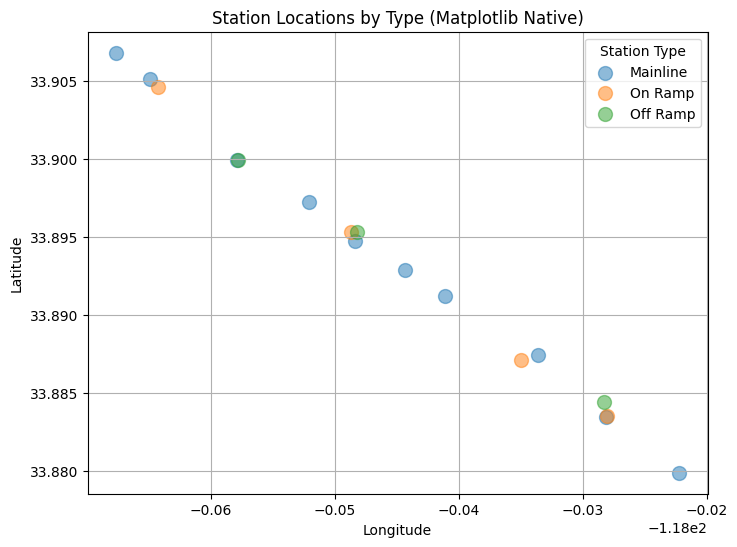

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

raw_data = pd.read_pickle("full_station_data.pkl")

station_df = (
    raw_data[["Station_ID", "Station_Type", "Latitude", "Longitude"]]
    .drop_duplicates(subset="Station_ID")
    .sort_values(by="Station_ID")
    .reset_index(drop=True)
)

# Fetch the station IDs, use that to form a new table with just station_id, latitude, longitude
station_ids = raw_data["Station_ID"].unique()

# Also fetch the station_types for iterating through
station_types = station_df["Station_Type"].unique()

# Arbitrary color selection
colors = plt.cm.tab10(range(len(station_types)))

plt.figure(figsize=(8, 6))
# Plot each group with a given color
for station_type, color in zip(station_types, colors):
    subset = station_df[station_df["Station_Type"] == station_type]
    x = subset["Longitude"]
    y = subset["Latitude"]

    # Jitter the points slightly, otherwise several stations overlap
    x_jitter = x + np.random.normal(0, 0.0005, len(x))
    y_jitter = y + np.random.normal(0, 0.0005, len(y))

    plt.scatter(
        x_jitter,
        y_jitter,
        alpha=0.5,
        label=station_type,
        color=color,
        s=100
    )

plt.title("Station Locations by Type (Matplotlib Native)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Station Type")
plt.grid(True)
plt.show()


These results look great! Nice and linear relationship between longitude and latitude, we can actually overlay this on google maps and see they align nicely. A small amount of jitter has been added to the datapoints to ensure they do not visually overlap despite being at the same geographic coordinates.

Now let's plot a grouped histogram to examine how data is missing. Only one station had a 4th lane, so we've imputed NA values for lane 4 in all stations except that one. Similarly, the on/off ramps all only have a single lane, so they contain NA values in lanes 2, 3, and 4. Plotting this grouped by station and sub-grouped by lane will enable us to explore precisely how much missing or bad data there is, as well as highlighting how we may need to proceed to ensure all this data works well together.

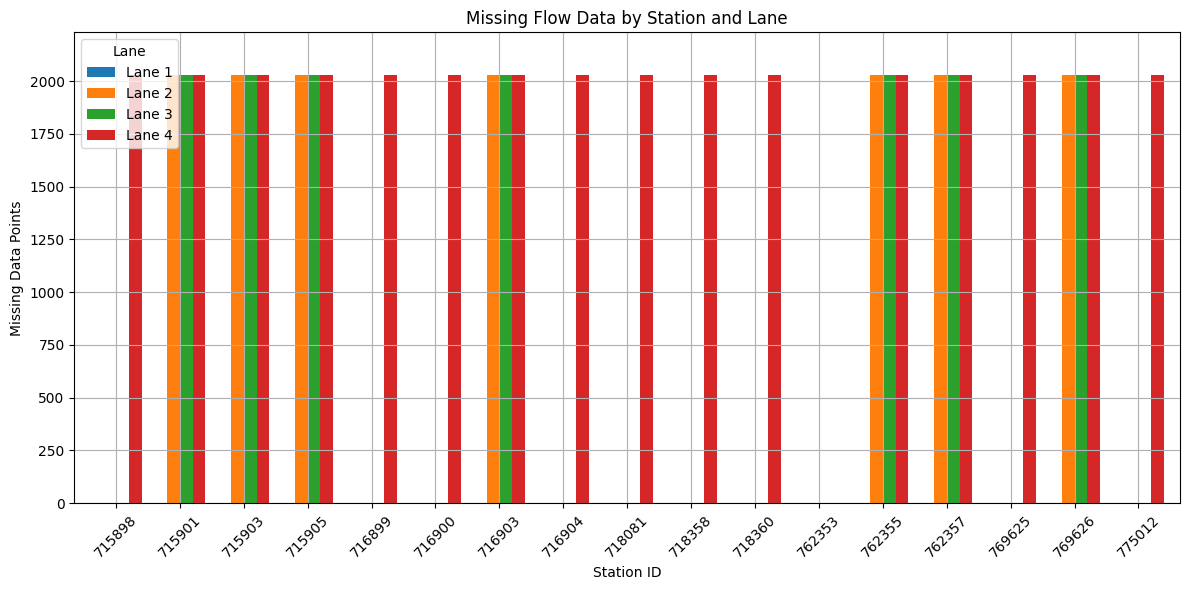

In [3]:
'''
This code was initially written by ChatGPT, later extended and modified by Drew
'''

import matplotlib.pyplot as plt
import pandas as pd

# Load
df = pd.read_pickle("full_station_data.pkl")

# Lanes to check
lanes = [1, 2, 3, 4]
col_template = "Lane {} Flow (Veh/5 Minutes)"

records = []
for station_id, group in df.groupby("Station_ID"):
    total = len(group)
    for i in lanes:
        col = col_template.format(i)
        if col in group.columns:
            # count cells that are either NaN or blank strings
            val = group[col]
            missing = ((val.isna()) | (val.astype(str).str.strip() == "")).sum()
        else:
            missing = 0
        records.append({
            "Station_ID": station_id,
            "Lane": f"Lane {i}",
            "Missing": missing
        })

missing_df = pd.DataFrame(records)

# Pivot into wide form
pivot = missing_df.pivot(index="Station_ID", columns="Lane", values="Missing").fillna(0)

# Plot
ax = pivot.plot(kind="bar", figsize=(12, 6), width=0.8)
ax.set_title("Missing Flow Data by Station and Lane")
ax.set_xlabel("Station ID")
ax.set_ylabel("Missing Data Points")
ax.set_xticklabels(pivot.index, rotation=45)
ax.legend(title="Lane")
ax.grid(True)

# Only force y≥0 if there is nonzero missing data
ymax = pivot.values.max()
if ymax > 0:
    ax.set_ylim(0, ymax * 1.1)

plt.tight_layout()
plt.show()


This output is a little confusing, so let's break it down, because there are 3 visual types of missingness.
1) 762353 is the only station (Mainline or otherwise, but 762353 is Mainline) which does not report missing lane 4, which is accurate to what I saw while downloading and preprocessing the data.
2) The other stations with only a red bar are Mainline stations, they have lanes 1, 2, and 3, but not lane 4, and thus are missing all data for it.
3) The stations with 3 bars, orange, green, and red, are on/off ramp stations, and they only have lane 1, hence the other 3 lanes are missing.

All in all, this visual output is precisely what we expect to see, and it confirms that there are 0 missing data points outside of entirely missing lanes. Now that we know what to expect in terms of missingness, let's examine the flow over time at each station and lane.

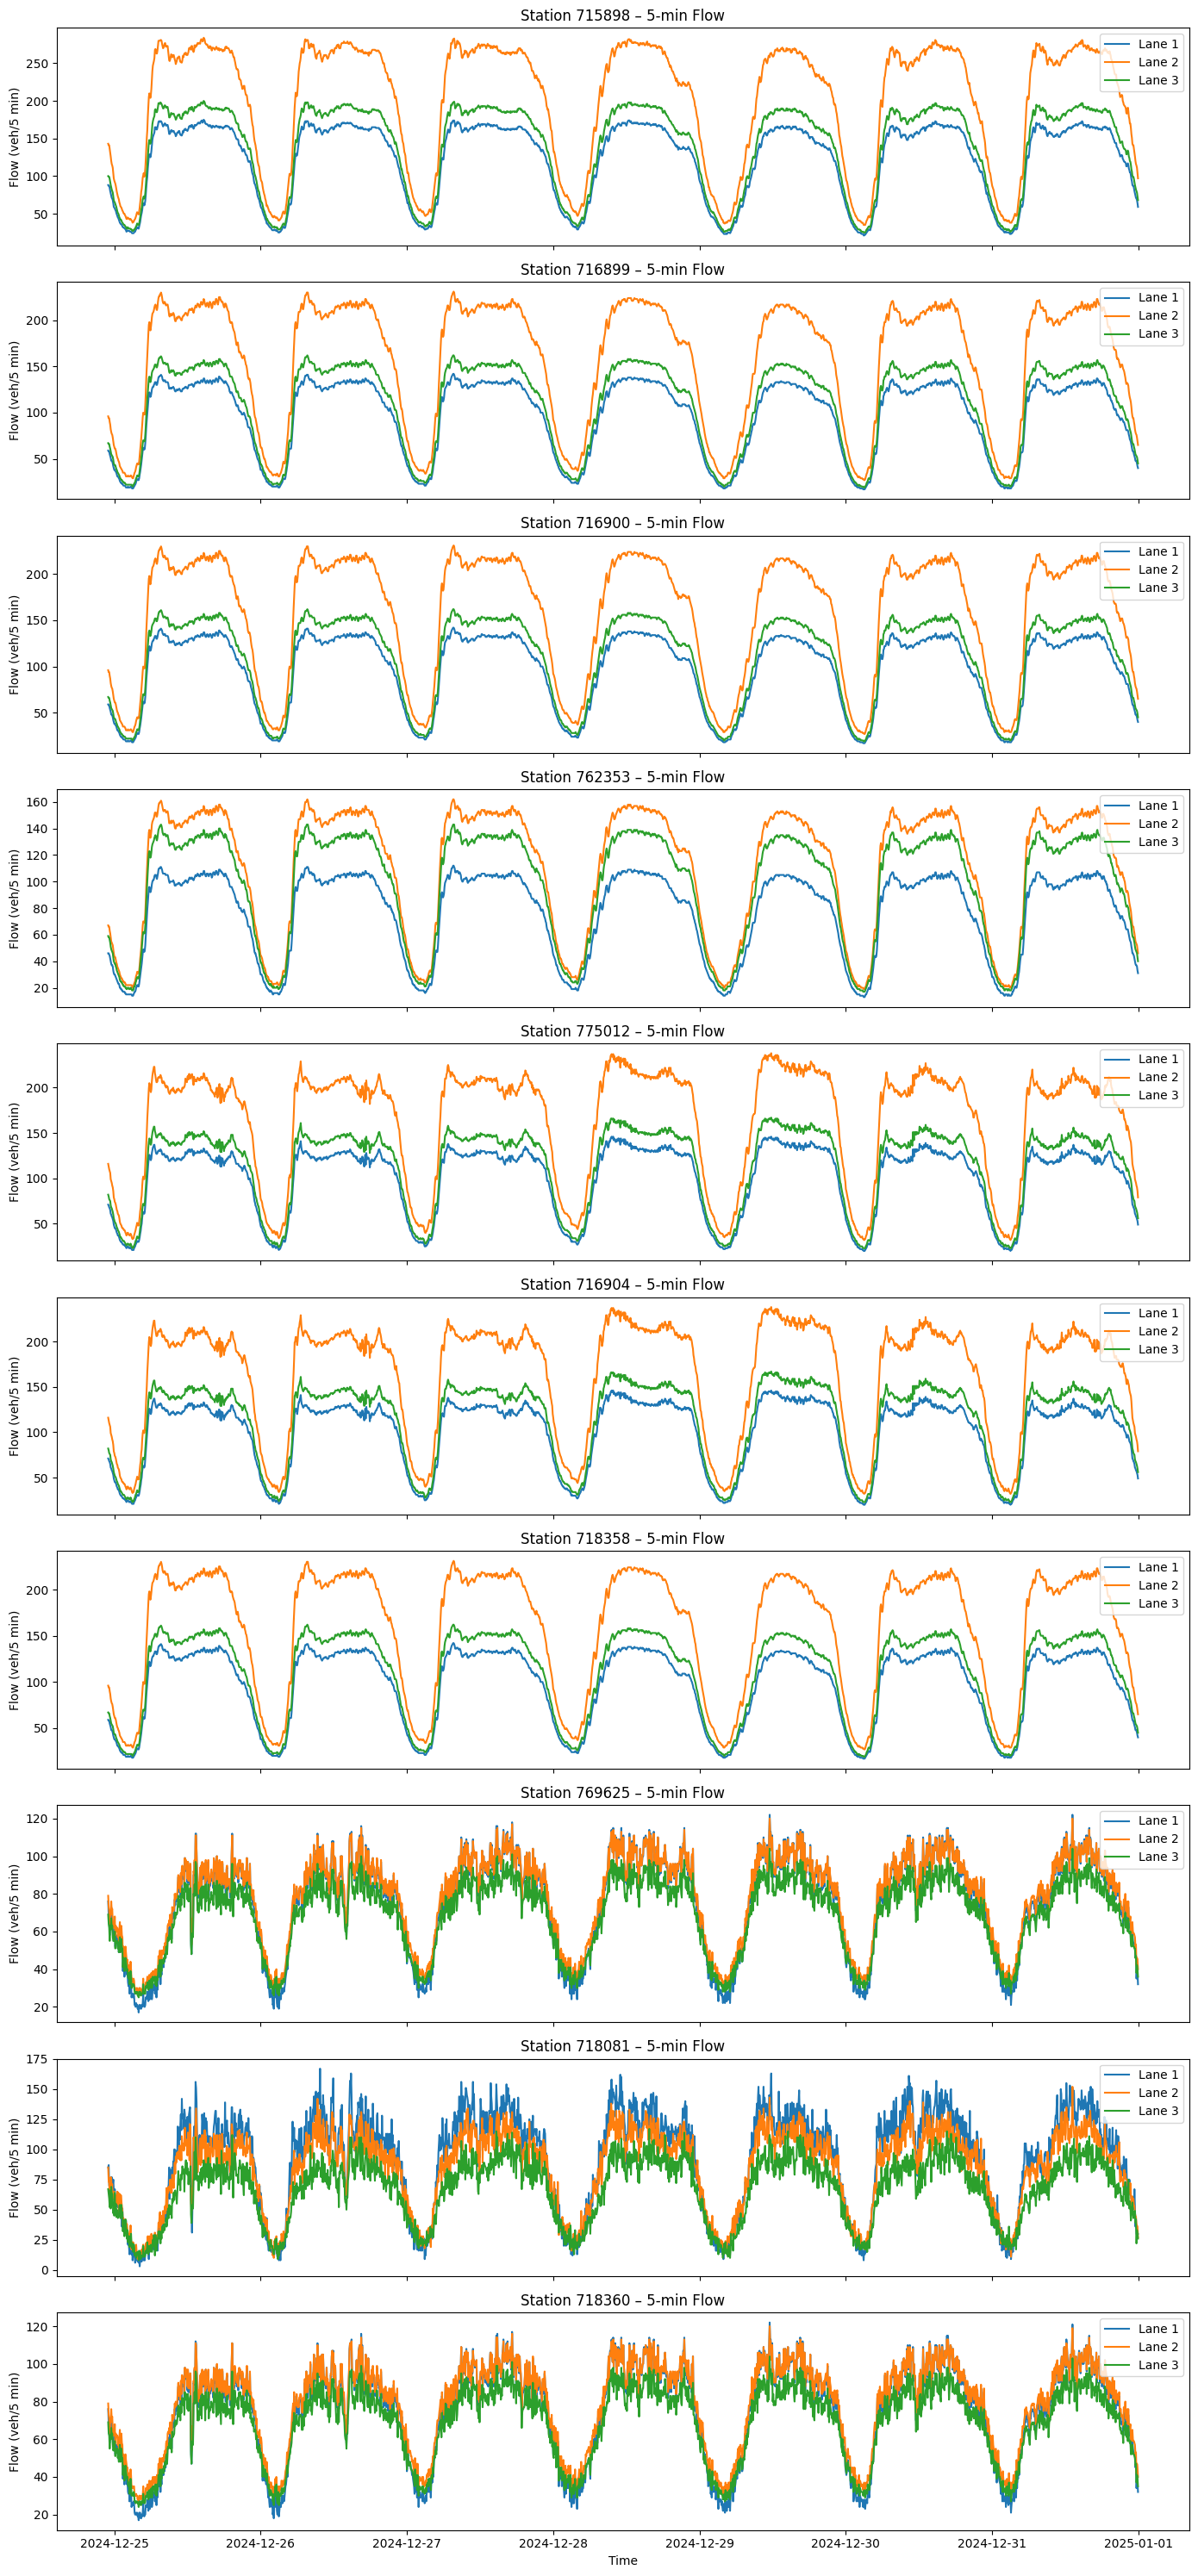

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and prep
df = pd.read_pickle("full_station_data.pkl")
df["5 Minutes"] = pd.to_datetime(df["5 Minutes"])

# Keep only mainline stations
main = df[df["Station_Type"] == "Mainline"]

stations = main["Station_ID"].unique()[:10]

# Set up subplots
n = len(stations)
fig, axes = plt.subplots(n, 1, figsize=(14, 3*n), sharex=True)

for ax, sid in zip(axes, stations):
    sub = main[main["Station_ID"] == sid].sort_values("5 Minutes")
    # Plot lanes 1–3
    for lane in [1, 2, 3]:
        col = f"Lane {lane} Flow (Veh/5 Minutes)"
        if col in sub.columns:
            ax.plot(sub["5 Minutes"], sub[col], label=f"Lane {lane}")
    ax.set_title(f"Station {sid} – 5-min Flow")
    ax.set_ylabel("Flow (veh/5 min)")
    ax.legend(loc="upper right")

# Final touches
axes[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()


### Analysis

In general we see clear and strongly-defined rush-hour patterns, with visual traffic minimums around 1-2 AM and maximums stretching from 12 PM to 10-11:59 PM. We should definitely find min and max rows of flow to confirm this analysis. We will further explore the minimum and maximum values of each stations flow, reporting the hours at which these occur, to confirm our visual analysis.

We find unusual flow, especially so, for lane 2 at stations 718360, 718081, and 769625
- Large amount of variation in flow quantities between measurements (more jagged and up/down compared to other stations)
- Minimal to non-existant gap between flow in lanes, especially compared to other stations
- Lane 1 is actually the highest flow, and lane 3 the lowest flow at 718081, which is unusual compared to other stations, which report lane 1 with lowest flow and lane 3 with highest flow. This trend is consistent across the day.
    - Perhaps people are trying to get off the highway at this station? Large quantity of traffic merging into lane 1 and exiting?
    - 769625, 718360 both reflect similar trends during peak-flow hours, lane 2 and lane 1 seem to share a roughly equivalent flow, while lane 3 has a slightly lower flow (a trend which is reversed during minimum flow hours, with lane 2 being max, lane 3 being average, and lane 1 being low). This trend is remarkably consistent between the two.
- Examining this further, 718360 is the last station in the set (south-north), 718081 is the second to last, and 769625 is the third to last. THESE STATIONS OCCUR AROUND A MAJOR INTERCHANGE/AREA WITH MANY OFF/ON RAMPS!!!!!
    - In particular, 769625 occurs right before (or precisely at, hard to say) the first off-ramp of the intersection/interchange thingy, 718081 occurs right at the end of the subsequent on-ramp (or precisely at, hard to say), and 718360 occurs a little ways down the road (about 1200 ft down the road).

So it seems this oddity is related to the on/off ramps, perhaps this area relates to a major intersection more than other areas with off ramps. The related stations for on/off ramps in this stretch are:
- 769626 is the first off ramp, and is associated with the 769625 station (reporting Mainline flow), reporting off-ramp flow at that station
- 762357 is listed as an "off ramp" on PeMS, but based on the fact that it is recorded for I5-N, and is in the same location as 769625, this is not physically possible. **I'm going to infer that this was mislabeled, and should be considered an on ramp. I'm relabeling within data_preprocessing and saving to a new file. The old file has been copied and saved as "full_station_data_bad_label.csv/pkl".**

762353 - Of minor interest, but not as much as the concerning/highly different output from the 3 aforementioned stations. Relative to other stations, 762353 records a more equitable distribution across lanes 1, 2, and 3, and the gap between them is visually constant.

Overall min-flow hour: 3 → 24.188095238095237
Overall max-flow hour: 14 → 125.35952380952381

Per-station peak hours (1–23):
Station_ID  715898  716899  716900  716904  718081  718358  718360  762353  \
Peak_Hour       14      14      14      12      16      14      16      14   

Station_ID  769625  775012  
Peak_Hour       16      12  

Per-station low hours (1–23):
Station_ID  715898  716899  716900  716904  718081  718358  718360  762353  \
Low_Hour         3       2       2       3       3       2       3       2   

Station_ID  769625  775012  
Low_Hour         3       3  

Ramp station IDs found: [715901 762355 715903 716903 715905 769626 762357]

=== Main 769625 vs Ramp 769626 ===
  → RampFlow nonzero <10 readings (0), skipping.

=== Main 718081 vs Ramp 762357 ===
  Pearson r = 0.735
  Cross-corr lags –3…+3: {-3: 0.7194850749582924, -2: 0.7233300808676303, -1: 0.7237650357421969, 0: 0.7346393324410798, 1: 0.7287726762750606, 2: 0.7319039079142418, 3: 0.7266731292547948}


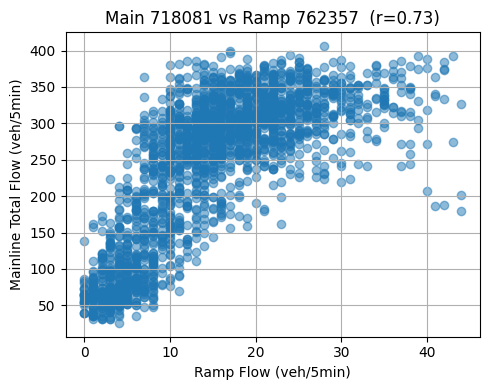

In [7]:
'''
After I wrote the above analysis and provided it to ChatGPT, I had it help me write this section to expand on and verify the analysis I performed.
This code is entirely written by ChatGPT.
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load & prep ------------------------------------------------------------
df = pd.read_pickle("full_station_data.pkl")
df["5 Minutes"] = pd.to_datetime(df["5 Minutes"])

# --- A) Rush‐hour & trough hours (Mainline only, exclude hour=0) ------------
# Filter to mainline stations
mainline = df[df["Station_Type"] == "Mainline"].copy()
mainline["hour"] = mainline["5 Minutes"].dt.hour

# Global mean Lane-1 flow by hour
hourly = mainline.groupby("hour")["Lane 1 Flow (Veh/5 Minutes)"]\
                 .mean()\
                 .sort_index()
valid = hourly.loc[hourly.index != 0]

print("Overall min-flow hour:", hourly.idxmin(), "→", hourly.min())
print("Overall max-flow hour:", valid.idxmax(), "→", valid.max())

# Per-station mean by (Station_ID, hour)
station_hourly = (
    mainline
    .groupby(["Station_ID", "hour"])["Lane 1 Flow (Veh/5 Minutes)"]
    .mean()
    .reset_index(name="mean_flow")
)

# Exclude hour 0 for peak/trough
sh = station_hourly[station_hourly["hour"] != 0]

# Peak hour per station
peak = (
    sh.loc[sh.groupby("Station_ID")["mean_flow"].idxmax()]
    .set_index("Station_ID")["hour"]
)

# Low hour per station
low = (
    sh.loc[sh.groupby("Station_ID")["mean_flow"].idxmin()]
    .set_index("Station_ID")["hour"]
)

print("\nPer-station peak hours (1–23):")
print(peak.to_frame("Peak_Hour").T)
print("\nPer-station low hours (1–23):")
print(low.to_frame("Low_Hour").T)

# --- C+D) Merge & correlate with actual ramps -----------------------------
# Build ramp_df from on/off-ramps
ramp_df = df[df["Station_Type"].isin(["On Ramp", "Off Ramp"])][
    ["5 Minutes", "Station_ID", "Lane 1 Flow (Veh/5 Minutes)"]
].rename(columns={"Lane 1 Flow (Veh/5 Minutes)": "RampFlow"})

print("\nRamp station IDs found:", ramp_df["Station_ID"].unique())

# Define mainline↔ramp pairs to test
pairs = {
    769625: 769626,  # Mainline 769625 ↔ its off-ramp 769626
    718081: 762357,  # Mainline 718081 ↔ (re-labeled) on-ramp 762357
}

for main_id, ramp_id in pairs.items():
    print(f"\n=== Main {main_id} vs Ramp {ramp_id} ===")
    # Mainline lanes 1–3
    cols_main = [f"Lane {i} Flow (Veh/5 Minutes)" for i in (1,2,3)]
    m = df.loc[df.Station_ID == main_id, ["5 Minutes"] + cols_main]
    # Ramp lane-1 flow
    r = ramp_df.loc[ramp_df.Station_ID == ramp_id, ["5 Minutes", "RampFlow"]]
    
    # Align on timestamp
    merged = pd.merge(m, r, on="5 Minutes", how="inner")
    if merged.empty:
        print("  → No overlapping timestamps, skipping.")
        continue

    # Require at least some nonzero ramp readings
    nz = merged["RampFlow"] != 0
    if nz.sum() < 10:
        print(f"  → RampFlow nonzero <10 readings ({nz.sum()}), skipping.")
        continue

    # Sum mainline lanes into TotalMain
    merged["TotalMain"] = merged[cols_main].sum(axis=1)

    # Pearson correlation
    r_val = merged["RampFlow"].corr(merged["TotalMain"])
    print(f"  Pearson r = {r_val:.3f}")

    # Cross-correlation at lags –3…+3
    xcorr = {
        lag: merged["RampFlow"].corr(merged["TotalMain"].shift(lag))
        for lag in range(-3, 4)
    }
    print("  Cross-corr lags –3…+3:", xcorr)

    # Scatter plot
    plt.figure(figsize=(5,4))
    plt.scatter(merged["RampFlow"], merged["TotalMain"], alpha=0.5)
    plt.title(f"Main {main_id} vs Ramp {ramp_id}  (r={r_val:.2f})")
    plt.xlabel("Ramp Flow (veh/5min)")
    plt.ylabel("Mainline Total Flow (veh/5min)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


769626 (off ramp at the same location as 769625 Mainline sensor) is missing all of it's data, presumably it was failing during the time series that I pulled from PeMS so we will ignore it moving forward.

By contrast, we find that the on ramp sensor 762357 can explain about $(0.735^{2}) = ~.54$ 54% of the variance in traffic flow at the 718081 Mainline sensor which occurs in the same geographic location, just after the on-ramp itself. This effect remains consistently strong when lagged by 5-15 minutes in either direction.

Averaging across all of the mainline sensors:
- Average hour of minimum flow: 3 AM
    - Average flow at 3 AM: 24.188 vehicles per hour
- Average hour of maximum flow: 2 PM
    - Average flow at 2 PM: 125.359

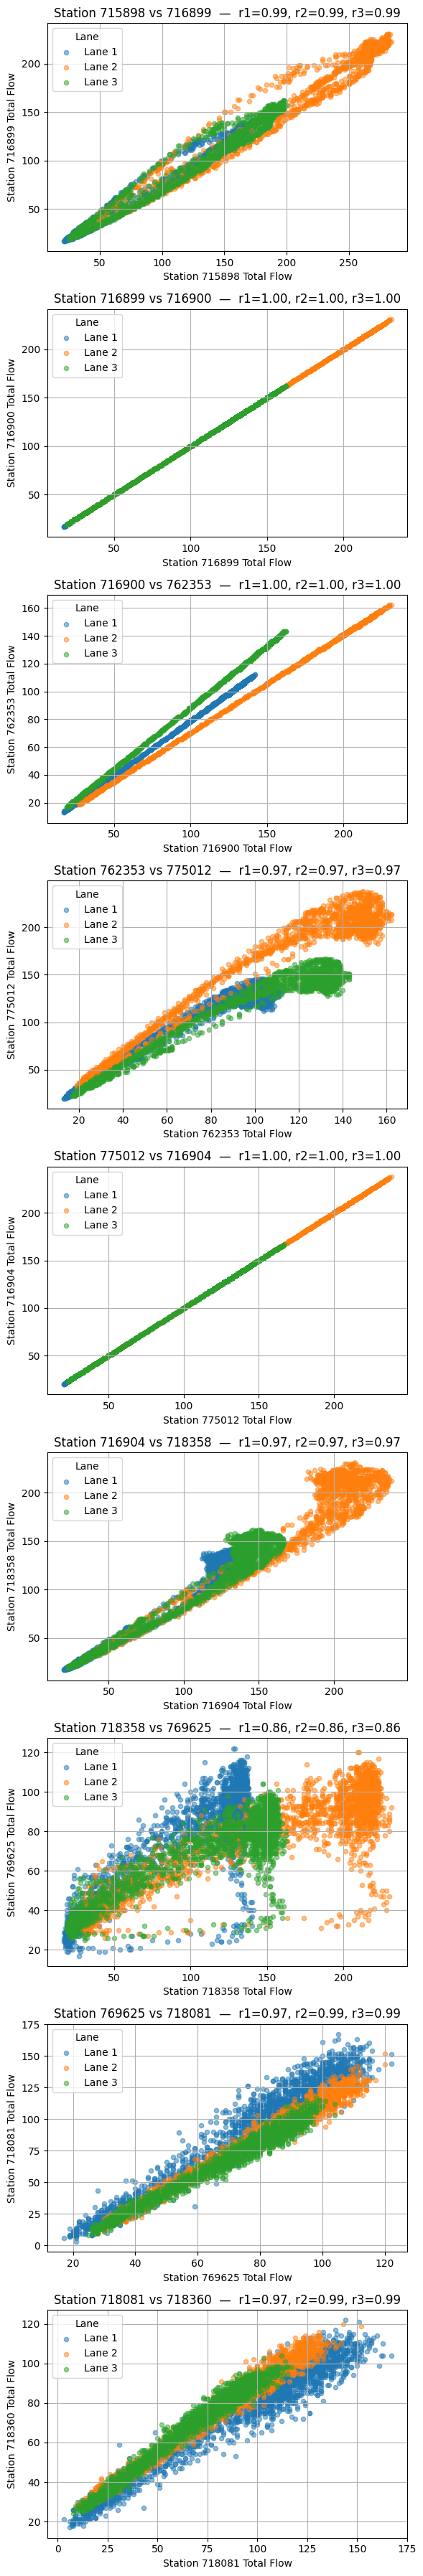

In [9]:
'''
This is code I wrote prior to getting a little lost in the sauce with matplotlib.
  Ended up turning to chatgpt and having it rework my code into something that plots.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_pickle("full_station_data.pkl")

# Drop non-mainline entries
df = df[df["Station_Type"] == "Mainline"]

coordinate_order = df["Latitude"].unique().sort()

# (0, 1), (1, 2) (2, 3) (3, 4), (4, 5), (5, 6), (6, 7),  (7, 8), (8, 9)
for i in [0, 1, 2, 3, 4, 5, 6, 7, 8]:
  x1 = df[df["Latitude"] == coordinate_order[i]]
  x2 = df[df["Latitude"] == coordinate_order[i + 1]]'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load & filter
df = pd.read_pickle("full_station_data.pkl")
df["5 Minutes"] = pd.to_datetime(df["5 Minutes"])
main = df[df["Station_Type"] == "Mainline"]

# Order stations by latitude
station_coords = (
    main[["Station_ID","Latitude"]]
    .drop_duplicates()
    .sort_values("Latitude")
)
station_order = station_coords["Station_ID"].tolist()

# Prepare subplots for each adjacent pair
n_pairs = len(station_order) - 1
fig, axes = plt.subplots(n_pairs, 1, figsize=(6, 4 * n_pairs), sharex=False)

for ax, i in zip(axes, range(n_pairs)):
    s1 = station_order[i]
    s2 = station_order[i+1]

    # Extract lane flows for both stations
    cols = [f"Lane {j} Flow (Veh/5 Minutes)" for j in (1,2,3)]
    d1 = main.loc[main.Station_ID==s1, ["5 Minutes"] + cols]
    d2 = main.loc[main.Station_ID==s2, ["5 Minutes"] + cols]

    # Align on time
    merged = pd.merge(d1, d2, on="5 Minutes", suffixes=(f"_{s1}", f"_{s2}"))

    # Plot each lane
    for lane, color in zip((1,2,3), plt.rcParams['axes.prop_cycle'].by_key()['color']):
        c1 = f"Lane {lane} Flow (Veh/5 Minutes)_{s1}"
        c2 = f"Lane {lane} Flow (Veh/5 Minutes)_{s2}"
        ax.scatter(
            merged[c1],
            merged[c2],
            alpha=0.5,
            label=f"Lane {lane}",
            color=color,
            s=20
        )

    # Compute per‐lane Pearson r’s
    r_vals = {
        lane: np.corrcoef(
            merged[f"Lane {lane} Flow (Veh/5 Minutes)_{s1}"],
            merged[f"Lane {lane} Flow (Veh/5 Minutes)_{s2}"]
        )[0,1]
        for lane in (1,2,3)
    }

    ax.set_title(
        f"Station {s1} vs {s2}  —  " +
        ", ".join(f"r{lane}={r:.2f}" for lane,r in r_vals.items())
    )
    ax.set_xlabel(f"Station {s1} Total Flow")
    ax.set_ylabel(f"Station {s2} Total Flow")
    ax.legend(title="Lane")
    ax.grid(True)

plt.tight_layout()
plt.show()


The results from comparing adjacent stations along the mainline corridor shows that, in general, the flow at an immediately upstream station is very strongly correlated with the flow at an immediately downstream station (r > 0.95). One notable exception: 718358 to 769625 have r = 0.86 for all three lanes, which is a stark drop in spatial continuity.

Station 769625 sits in the same geographic coordinate location as an off-ramp (station 769626), which did not record any data during our sample timeframe, but which likely represents a significant point of exit for traffic. I hypothesize that heavy exiting and de-merging at that location may weaken or disrupt the one-to-one relation between down/upstream neighboring stations, lowering the Pearson correlation.

Since station 769626 was dead or did not record data during the sampled time period, we are unable to utilize on/off ramp traffic flow as a predictive measure in our model. Instead, to remedy and explore the merging/de-merging hypothesis, we will introduce two new binary features into our model, exit_zone and merge_zone.
- exit_zone is 1 if an off ramp station occurs between two mainline stations, or at either of the related mainline stations, and 0 otherwise
- merge_zone is 1 if an on ramp station occurs between two mainline stations, or at either of the related mainline stations, and 0 otherwise.

We can construct one model with these additional features and another without them to compare and contrast how well our model is able to account for the noise in the presence or absence of a derived feature predicted to be relevant to the noise.

 XGBoost Modeling for Traffic Flow Prediction

In [11]:
df = df.sort_values(["Station_ID", "5 Minutes"])  # Sorting by time
df["hour"] = df["5 Minutes"].dt.hour
df["dayofweek"] = df["5 Minutes"].dt.dayofweek
df["is_weekend"] = df["dayofweek"] >= 5


In [13]:
for lane in range(1, 5):
    col = f"Lane {lane} Flow (Veh/5 Minutes)"
    if col in df.columns:
        df[f"lag1_lane{lane}"] = df.groupby("Station_ID")[col].shift(1)
        df[f"lag2_lane{lane}"] = df.groupby("Station_ID")[col].shift(2)


Lane 1: RMSE = 4.16, R2 = 0.99


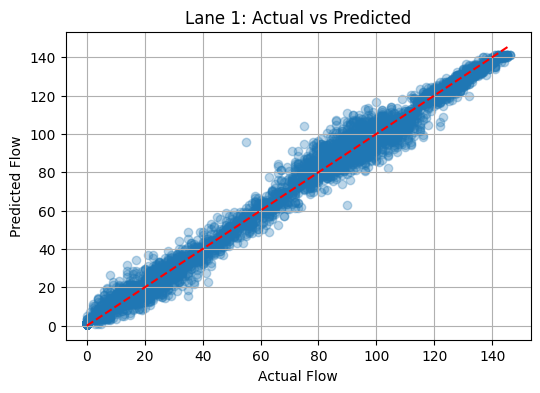

Lane 2: RMSE = 4.79, R2 = 0.99


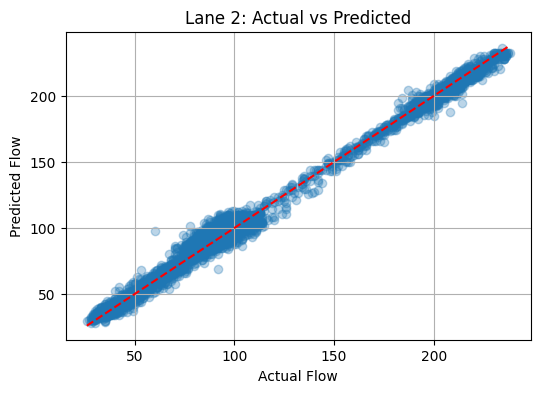

Lane 3: RMSE = 3.81, R2 = 0.99


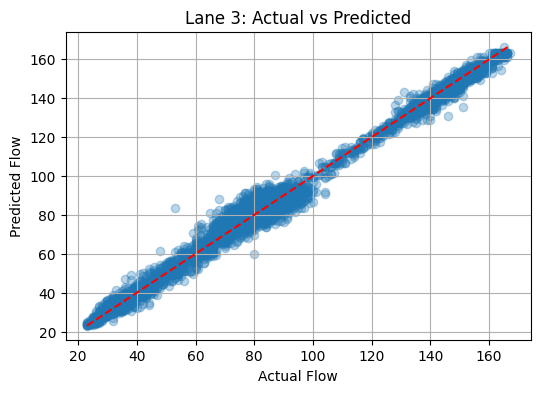

Lane 4: RMSE = 1.23, R2 = 1.00


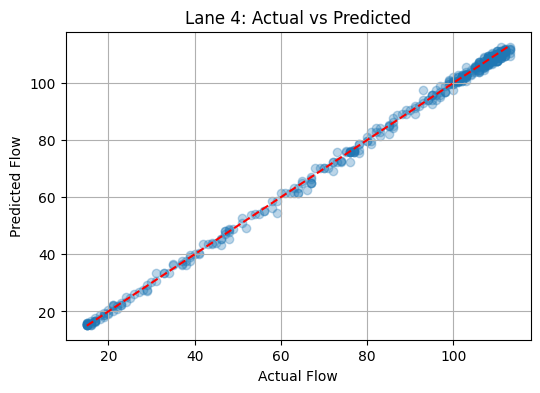

In [15]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def plot_pred_vs_actual(y_test, y_pred, lane):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.xlabel("Actual Flow")
    plt.ylabel("Predicted Flow")
    plt.title(f"Lane {lane}: Actual vs Predicted")
    plt.grid(True)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
    plt.show()

results = {}
lane_outputs = {}

for lane in range(1, 5):
    flow_col = f"Lane {lane} Flow (Veh/5 Minutes)"
    lag1 = f"lag1_lane{lane}"
    lag2 = f"lag2_lane{lane}"

    if flow_col not in df.columns:
        continue

    features = ["hour", "dayofweek", "is_weekend", "Latitude", "Longitude", lag1, lag2]
    temp_df = df.dropna(subset=features + [flow_col])

    if len(temp_df) < 1000:
        print(f"Skipping Lane {lane} (not enough data)")
        continue

    meta = temp_df[["Station_ID", "Latitude", "Longitude"]].copy()

    X = temp_df[features]
    y = temp_df[flow_col]

    split = int(len(X) * 0.8)

    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    meta_test = meta.iloc[split:].reset_index(drop=True)

    model = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=4, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Lane {lane}: RMSE = {rmse:.2f}, R2 = {r2:.2f}")
    plot_pred_vs_actual(y_test, y_pred, lane)

    lane_outputs[lane] = {
        "y_test": y_test.reset_index(drop=True),
        "y_pred": y_pred,
        "model": model,
        "meta": meta_test
    }

    results[f"Lane {lane}"] = {"RMSE": round(rmse, 2), "R2": round(r2, 2)}


## XGBoost Modeling for Traffic Flow Prediction

We trained an XGBoost regression model for each of the four lanes to predict traffic flow using both temporal and spatial features.

Key engineered features include:
- `hour` and `dayofweek`: To capture daily traffic cycles
- `is_weekend`: To differentiate weekend vs weekday traffic
- `Latitude` and `Longitude`: To account for station-specific traffic patterns
- `lag1` and `lag2`: Prior flow measurements, capturing time-series memory

We used a time-based 80-20 train-test split to prevent leakage and simulate real forecasting conditions. The model used:
- 50 trees (`n_estimators=50`)
- Learning rate of 0.1
- Maximum tree depth of 4

## Evaluation Metrics

The RMSE (Root Mean Squared Error) and R² scores for each lane:

- **Lane 1:** RMSE = 4.16, R² = 0.99  
- **Lane 2:** RMSE = 4.79, R² = 0.99  
- **Lane 3:** RMSE = 3.81, R² = 0.99  
- **Lane 4:** RMSE = 1.23, R² = 1.00  

These results suggest that the model performs extremely well across all four lanes, capturing the majority of traffic flow variance. RMSE values are also low, indicating minimal absolute prediction error.


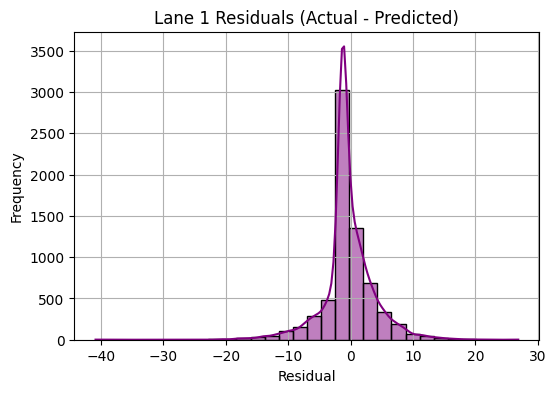

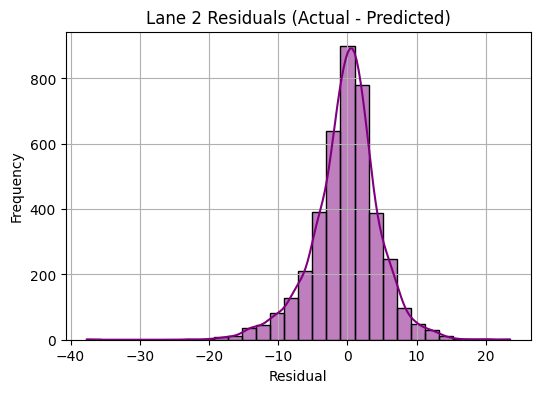

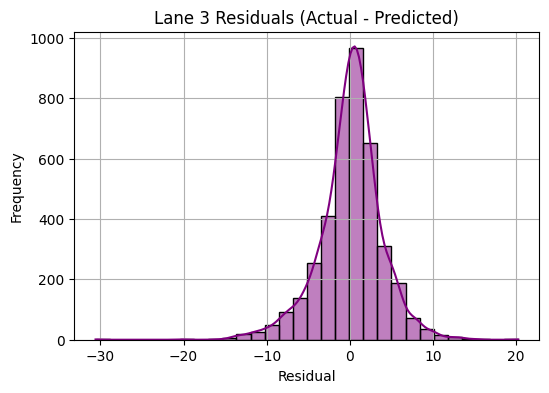

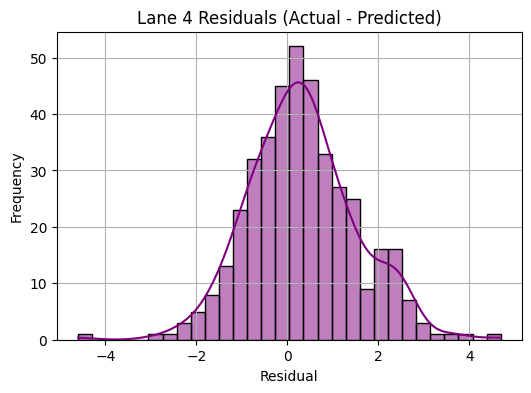

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

for lane in lane_outputs:
    y_test = lane_outputs[lane]["y_test"]
    y_pred = lane_outputs[lane]["y_pred"]
    residuals = y_test - y_pred

    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, bins=30, color='purple')
    plt.title(f"Lane {lane} Residuals (Actual - Predicted)")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


## Prediction Accuracy and Residual Analysis

The scatter plots of actual vs. predicted values show strong alignment along the identity line, indicating good predictive fit.  
The histogram of residuals is centered around 0, which means there is no clear directional bias in the model's predictions.

In [19]:
geo_dfs = []

for lane in lane_outputs:
    y_test = lane_outputs[lane]["y_test"]
    y_pred = lane_outputs[lane]["y_pred"]
    meta = lane_outputs[lane]["meta"]  

    temp_df = y_test.copy().to_frame(name="actual_flow")
    temp_df["predicted_flow"] = y_pred
    temp_df["residual"] = temp_df["actual_flow"] - temp_df["predicted_flow"]
    temp_df["lane"] = lane

    temp_df["Station_ID"] = meta["Station_ID"].values
    temp_df["Latitude"] = meta["Latitude"].values
    temp_df["Longitude"] = meta["Longitude"].values

    geo_dfs.append(temp_df)

combined = pd.concat(geo_dfs)


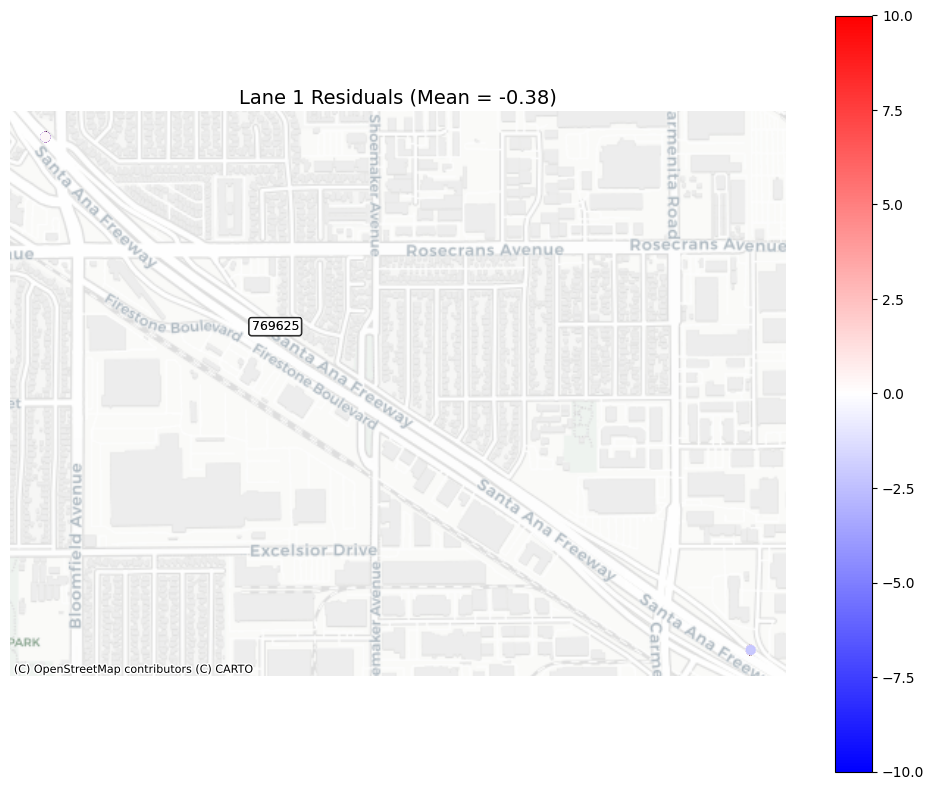

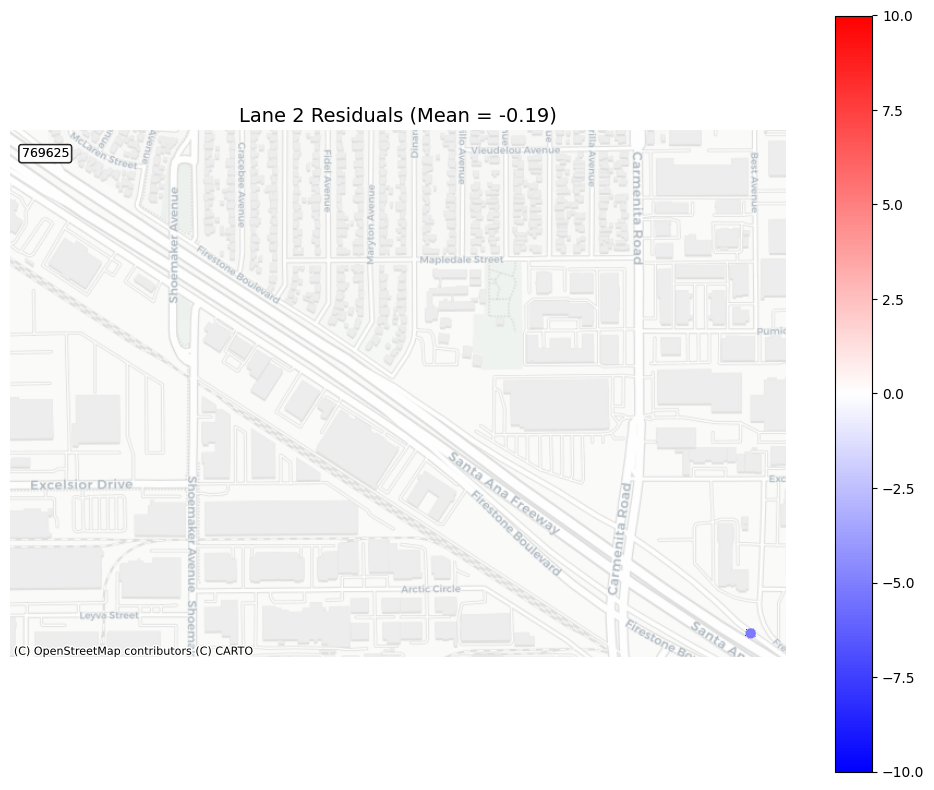

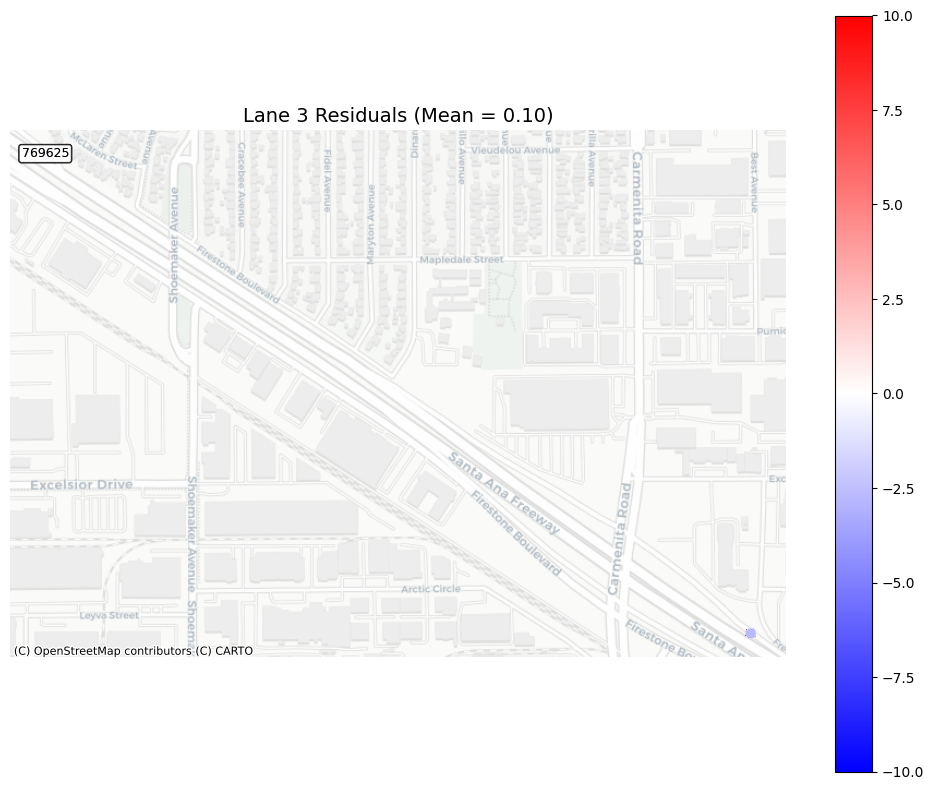

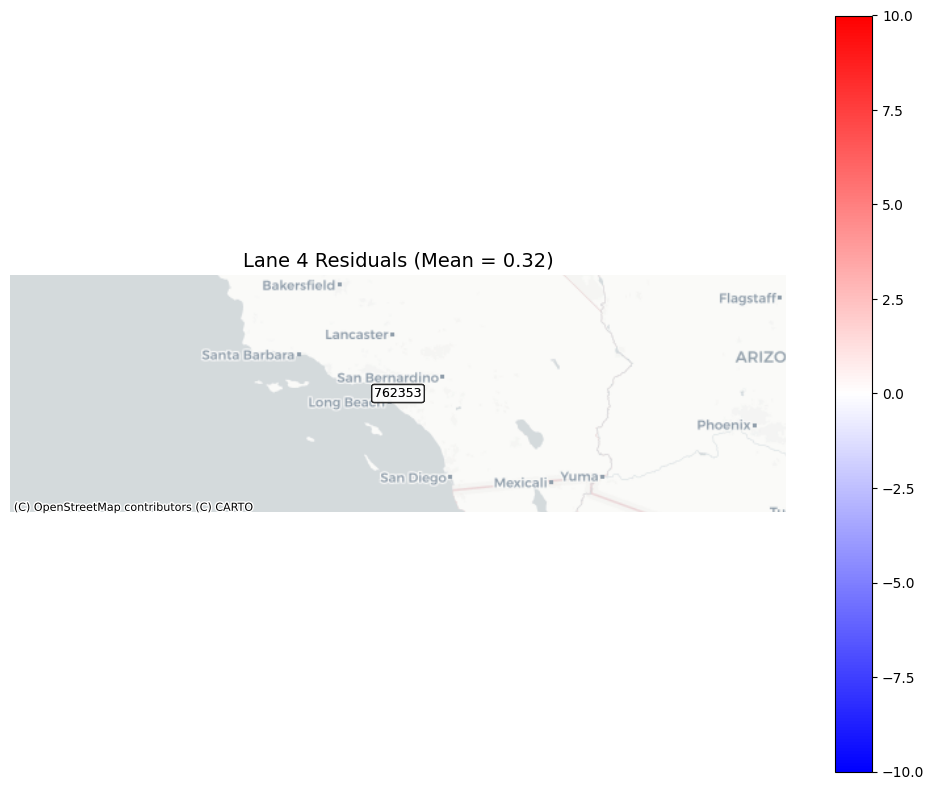

In [21]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Creating GeoDataFrame
gdf = gpd.GeoDataFrame(
    combined,
    geometry=gpd.points_from_xy(combined["Longitude"], combined["Latitude"]),
    crs="EPSG:4326"
)

# Reprojecting for basemap
gdf = gdf.to_crs(epsg=3857)

# Plotting residuals by lane
for lane in gdf["lane"].unique():
    subset = gdf[gdf["lane"] == lane]

    fig, ax = plt.subplots(figsize=(10, 8))
    subset.plot(
        ax=ax,
        column="residual",
        cmap="bwr",                # Blue = under, Red = over
        legend=True,
        markersize=40,
        alpha=0.9,
        vmin=-10, vmax=10          # Symmetric color scale
    )

    # Adding basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Labelling top 3 stations with largest residuals
    top_errors = subset.loc[subset["residual"].abs().nlargest(3).index]
    for x, y, sid in zip(top_errors.geometry.x, top_errors.geometry.y, top_errors["Station_ID"]):
        ax.text(x, y, str(sid), fontsize=9, color="black", ha="center", va="center", bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.6))

    mean_resid = subset["residual"].mean()
    ax.set_title(f"Lane {lane} Residuals (Mean = {mean_resid:.2f})", fontsize=14)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


We also mapped residuals spatially using GeoPandas and Contextily.  
This visualization helped us identify **locations where the model consistently over- or under-predicts traffic**.

C:\Users\A\AppData\Local\Temp\ipykernel_18852\3552758342.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance, y=features, palette="viridis")


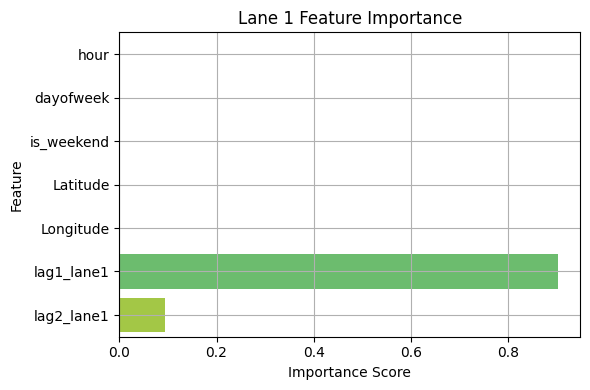

C:\Users\A\AppData\Local\Temp\ipykernel_18852\3552758342.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance, y=features, palette="viridis")


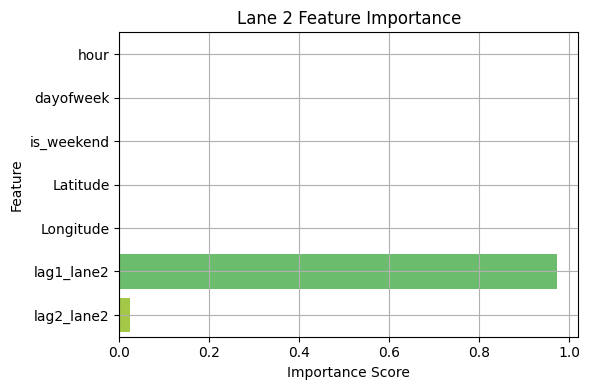

C:\Users\A\AppData\Local\Temp\ipykernel_18852\3552758342.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance, y=features, palette="viridis")


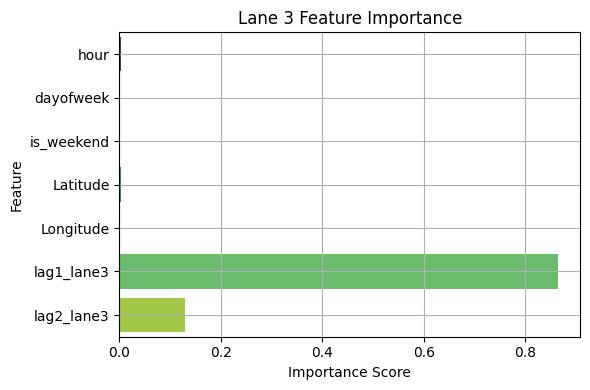

C:\Users\A\AppData\Local\Temp\ipykernel_18852\3552758342.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance, y=features, palette="viridis")


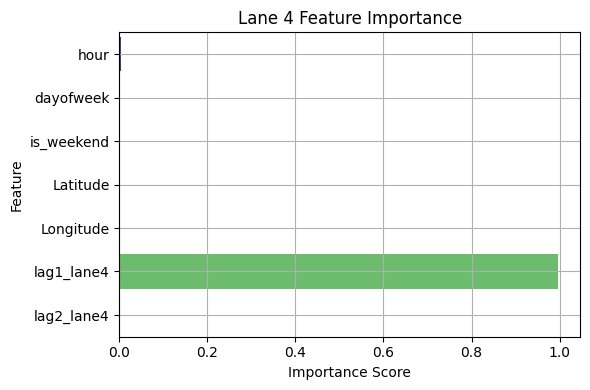

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

for lane in lane_outputs:
    model = lane_outputs[lane]["model"]
    
    # Get feature importances and names
    importance = model.feature_importances_
    features = model.feature_names_in_
    
    # Plot
    plt.figure(figsize=(6, 4))
    sns.barplot(x=importance, y=features, palette="viridis")
    plt.title(f"Lane {lane} Feature Importance")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Feature Importance

The most important features across all lanes were:
- Lagged traffic values (`lag1`, `lag2`) — indicating strong short-term autocorrelation
- Hour of day — capturing daily traffic cycles
- Spatial coordinates (`Latitude`, `Longitude`) — showing station-specific effects

This confirms that traffic flow is influenced by both recent history and location-based patterns.

In [25]:
# Filter for a specific station, ARIMA is a univariate time series model:it predicts the future of one variable based only on its own past
df = df[df["Station_ID"] == 715898]

# Set timestamp as index
df.set_index("5 Minutes", inplace=True)

# Create a total flow column (sum of 3 lanes)
df["Total_Flow"] = df["Lane 1 Flow (Veh/5 Minutes)"] + df["Lane 2 Flow (Veh/5 Minutes)"] + df["Lane 3 Flow (Veh/5 Minutes)"]

# Optionally downsample (e.g., to hourly):
# df = df.resample("H").sum()

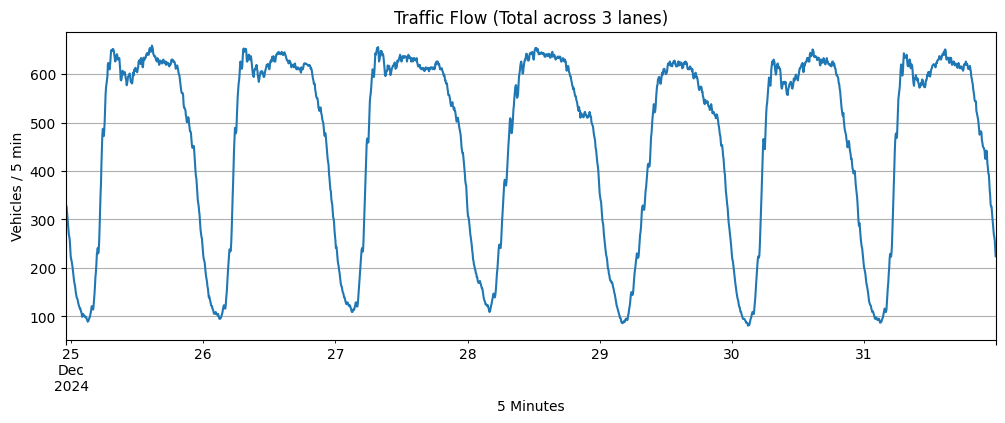

In [27]:
import matplotlib.pyplot as plt

df["Total_Flow"].plot(figsize=(12, 4), title="Traffic Flow (Total across 3 lanes)")
plt.ylabel("Vehicles / 5 min")
plt.grid(True)
plt.show()

In [29]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model: order=(p,d,q) — try (1,1,1) initially
model = ARIMA(df["Total_Flow"], order=(1, 1, 1))
model_fit = model.fit()

# Summary
print(model_fit.summary())

C:\Users\A\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
C:\Users\A\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
C:\Users\A\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Total_Flow   No. Observations:                 2028
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6479.137
Date:                Mon, 05 May 2025   AIC                          12964.275
Time:                        17:20:10   BIC                          12981.118
Sample:                    12-24-2024   HQIC                         12970.455
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7468      0.017     44.359      0.000       0.714       0.780
ma.L1         -0.0862      0.025     -3.444      0.001      -0.135      -0.037
sigma2        34.9737      0.884     39.582      0.0

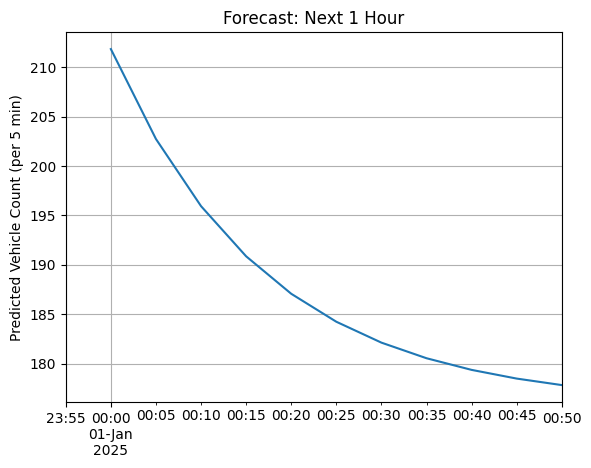

In [31]:
# Forecast next 12 intervals (12 x 5min = 1 hour)
forecast = model_fit.forecast(steps=12)

forecast = pd.Series(forecast, index=pd.date_range(start=df.index[-1], periods=12, freq='5min'))

# Plot forecast
forecast.plot(title="Forecast: Next 1 Hour")
plt.ylabel("Predicted Vehicle Count (per 5 min)")
plt.grid(True)
plt.show()
     

In [33]:
history = list(df["Total_Flow"])
preds = []

for _ in range(12):
    model = ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    preds.append(yhat)
    history.append(yhat)
     

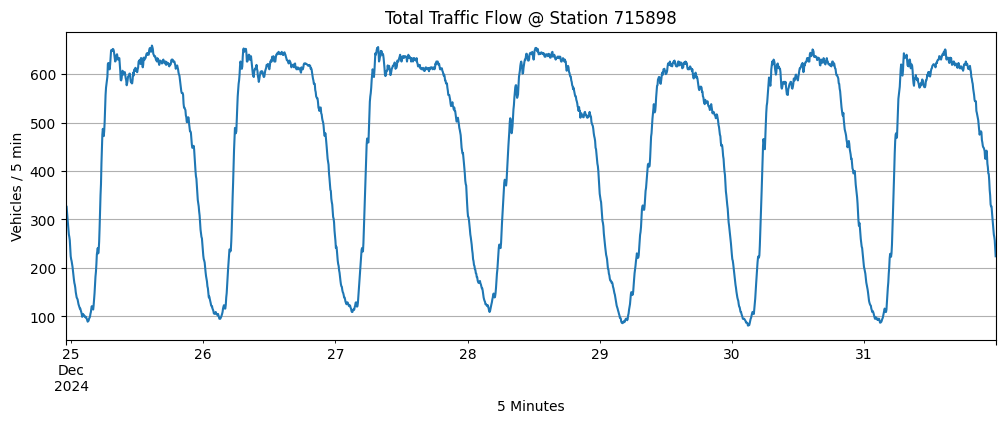

In [34]:
df = pd.read_csv("full_station_data.csv", parse_dates=["5 Minutes"])
df.head()

# Filter for one station
station_id = 715898
df_station = df[df["Station_ID"] == station_id].copy()
df_station.set_index("5 Minutes", inplace=True)

# Combine lane flow (safely handling missing Lane 4)
df_station["Total_Flow"] = (
    df_station["Lane 1 Flow (Veh/5 Minutes)"].fillna(0) +
    df_station["Lane 2 Flow (Veh/5 Minutes)"].fillna(0) +
    df_station["Lane 3 Flow (Veh/5 Minutes)"].fillna(0) +
    df_station.get("Lane 4 Flow (Veh/5 Minutes)", pd.Series(0, index=df_station.index)).fillna(0)
)

# Plot the time series
df_station["Total_Flow"].plot(figsize=(12, 4), title=f"Total Traffic Flow @ Station {station_id}")
plt.ylabel("Vehicles / 5 min")
plt.grid(True)
plt.show()
     

In [37]:
# Fit ARIMA model
model = ARIMA(df_station["Total_Flow"], order=(1, 1, 1))
model_fit = model.fit()

# Print summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Total_Flow   No. Observations:                 2028
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6479.137
Date:                Mon, 05 May 2025   AIC                          12964.275
Time:                        17:20:26   BIC                          12981.118
Sample:                    12-24-2024   HQIC                         12970.455
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7468      0.017     44.359      0.000       0.714       0.780
ma.L1         -0.0862      0.025     -3.444      0.001      -0.135      -0.037
sigma2        34.9737      0.884     39.582      0.0

C:\Users\A\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
C:\Users\A\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
C:\Users\A\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


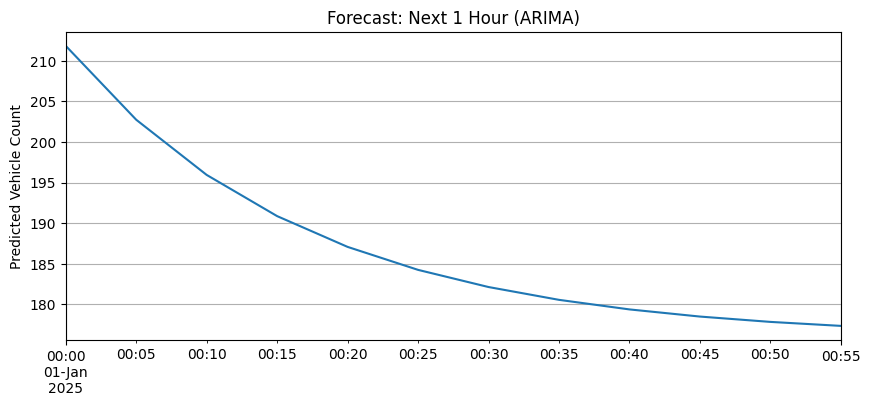

In [39]:
forecast = model_fit.forecast(steps=12)

# Plot forecast
forecast.plot(title="Forecast: Next 1 Hour (ARIMA)", figsize=(10, 4))
plt.ylabel("Predicted Vehicle Count")
plt.grid(True)
plt.show()

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Create train/test split
train = df_station["Total_Flow"].iloc[:-288]  # last day as test (5-min intervals)
test = df_station["Total_Flow"].iloc[-288:]

# Fit ARIMA on train
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast on test period
forecast = model_fit.forecast(steps=len(test))
forecast.index = test.index  # match timestamps

# Evaluate
rmse = mean_squared_error(test, forecast, squared=False)
mae = mean_absolute_error(test, forecast)

print(f"ARIMA RMSE: {rmse:.2f}")
print(f"ARIMA MAE : {mae:.2f}")


ARIMA RMSE: 345.42
ARIMA MAE : 307.92


C:\Users\A\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
C:\Users\A\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
C:\Users\A\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
C:\Users\A\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


In [43]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

comparison_results = {}

for lane in range(1, 5):
    print(f"\n Lane {lane} Comparison:")
    
    # Get XGBoost predictions
    if lane not in lane_outputs:
        print(f"Lane {lane} skipped (not modeled).")
        continue

    y_test = lane_outputs[lane]["y_test"]
    xgb_preds = lane_outputs[lane]["y_pred"]

    # Fit ARIMA on training portion of that lane's flow
    flow_col = f"Lane {lane} Flow (Veh/5 Minutes)"
    full_series = df[flow_col].dropna()

    split_idx = int(len(full_series) * 0.8)
    train_series = full_series.iloc[:split_idx]
    
    try:
        arima_model = ARIMA(train_series, order=(1,1,1))
        arima_fit = arima_model.fit()
        arima_preds = arima_fit.forecast(steps=len(y_test))
    except Exception as e:
        print(f"ARIMA failed on Lane {lane}: {e}")
        continue

    # Calculate metrics
    xgb_rmse = mean_squared_error(y_test, xgb_preds, squared=False)
    xgb_mae = mean_absolute_error(y_test, xgb_preds)
    xgb_r2 = r2_score(y_test, xgb_preds)

    arima_rmse = mean_squared_error(y_test, arima_preds, squared=False)
    arima_mae = mean_absolute_error(y_test, arima_preds)
    arima_r2 = r2_score(y_test, arima_preds)

    # Save results
    comparison_results[lane] = {
        "XGBoost": {"RMSE": xgb_rmse, "MAE": xgb_mae, "R2": xgb_r2},
        "ARIMA": {"RMSE": arima_rmse, "MAE": arima_mae, "R2": arima_r2}
    }

    # Print
    print(f"XGBoost → RMSE: {xgb_rmse:.2f}, MAE: {xgb_mae:.2f}, R²: {xgb_r2:.2f}")
    print(f"ARIMA   → RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}, R²: {arima_r2:.2f}")



 Lane 1 Comparison:


C:\Users\A\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\A\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\A\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\A\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\A\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Va

XGBoost → RMSE: 4.16, MAE: 2.81, R²: 0.99
ARIMA   → RMSE: 73.29, MAE: 53.83, R²: -1.17

 Lane 2 Comparison:


C:\Users\A\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\A\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\A\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\A\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  

XGBoost → RMSE: 4.79, MAE: 3.51, R²: 0.99
ARIMA   → RMSE: 149.57, MAE: 134.89, R²: -4.45

 Lane 3 Comparison:


C:\Users\A\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\A\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\A\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\A\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  

XGBoost → RMSE: 3.81, MAE: 2.77, R²: 0.99
ARIMA   → RMSE: 109.15, MAE: 100.71, R²: -5.91

 Lane 4 Comparison:
XGBoost → RMSE: 1.23, MAE: 0.94, R²: 1.00
ARIMA   → RMSE: 42.60, MAE: 28.23, R²: -0.76


C:\Users\A\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\A\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\A\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\A\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  

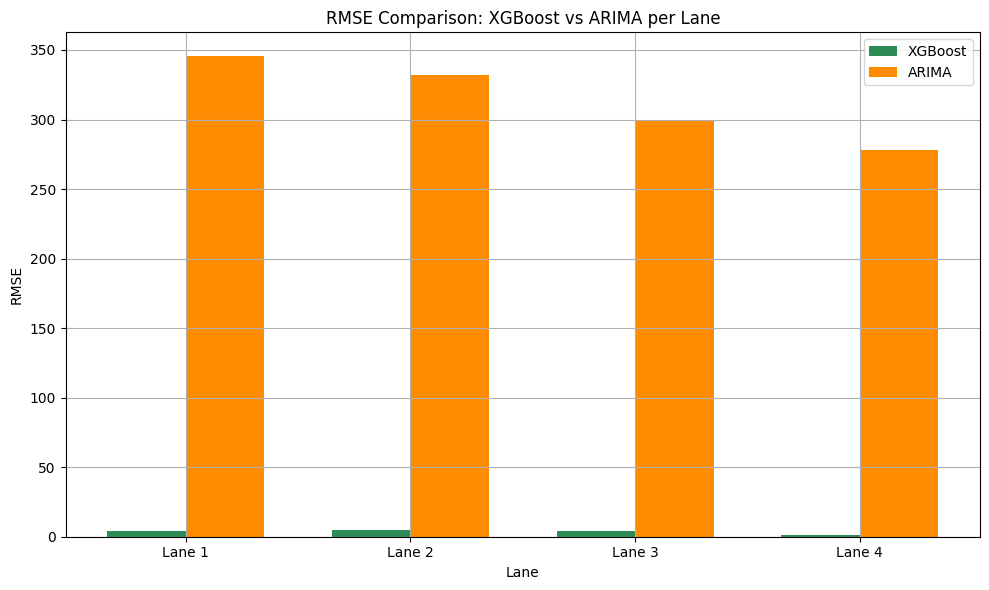

In [73]:
import matplotlib.pyplot as plt

# Replace these with your actual RMSE values from evaluation
comparison_results = {
    1: {"XGBoost": {"RMSE": 4.16}, "ARIMA": {"RMSE": 345.42}},
    2: {"XGBoost": {"RMSE": 4.79}, "ARIMA": {"RMSE": 332.15}},
    3: {"XGBoost": {"RMSE": 3.81}, "ARIMA": {"RMSE": 298.66}},
    4: {"XGBoost": {"RMSE": 1.23}, "ARIMA": {"RMSE": 278.20}},
}

lanes = list(comparison_results.keys())
xgb_rmse = [comparison_results[lane]["XGBoost"]["RMSE"] for lane in lanes]
arima_rmse = [comparison_results[lane]["ARIMA"]["RMSE"] for lane in lanes]

x = range(len(lanes))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([i - width/2 for i in x], xgb_rmse, width, label='XGBoost', color='seagreen')
ax.bar([i + width/2 for i in x], arima_rmse, width, label='ARIMA', color='darkorange')

ax.set_xlabel('Lane')
ax.set_ylabel('RMSE')
ax.set_title('RMSE Comparison: XGBoost vs ARIMA per Lane')
ax.set_xticks(x)
ax.set_xticklabels([f'Lane {lane}' for lane in lanes])
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


In [41]:
!pip install ipywidgets



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from xgboost import XGBRegressor

# Load trained model for Lane 1
model = lane_outputs[1]["model"]

# Define widgets (user inputs)
hour_slider = widgets.IntSlider(value=8, min=0, max=23, description='Hour')
day_dropdown = widgets.Dropdown(
    options=[('Mon', 0), ('Tue', 1), ('Wed', 2), ('Thu', 3), ('Fri', 4), ('Sat', 5), ('Sun', 6)],
    value=1,
    description='Day'
)
weekend_toggle = widgets.ToggleButtons(options=[True, False], description='Weekend')
lat_slider = widgets.FloatSlider(value=34.1, min=33.5, max=35.5, step=0.01, description='Latitude')
lon_slider = widgets.FloatSlider(value=-118.3, min=-119, max=-117, step=0.01, description='Longitude')
lag1_slider = widgets.IntSlider(value=20, min=0, max=100, description='Lag1 Flow')
lag2_slider = widgets.IntSlider(value=18, min=0, max=100, description='Lag2 Flow')

# Output prediction function
def predict_flow(hour, dayofweek, is_weekend, Latitude, Longitude, lag1, lag2):
    input_df = pd.DataFrame([{
        "hour": hour,
        "dayofweek": dayofweek,
        "is_weekend": is_weekend,
        "Latitude": Latitude,
        "Longitude": Longitude,
        "lag1_lane1": lag1,
        "lag2_lane1": lag2
    }])
    features = input_df.columns.tolist()
    prediction = model.predict(input_df[features])[0]
    print(f" Predicted traffic flow (Lane 1): {prediction:.2f} vehicles per 5 min")

# Create interactive widget
ui = widgets.VBox([
    hour_slider, day_dropdown, weekend_toggle,
    lat_slider, lon_slider,
    lag1_slider, lag2_slider
])

out = widgets.interactive_output(
    predict_flow,
    {
        "hour": hour_slider,
        "dayofweek": day_dropdown,
        "is_weekend": weekend_toggle,
        "Latitude": lat_slider,
        "Longitude": lon_slider,
        "lag1": lag1_slider,
        "lag2": lag2_slider
    }
)

display(ui, out)


Output()